In [1]:
from scipy.stats import norm, expon
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Data

### Generation

In [4]:
## PDFs
sig_mass_distr = norm(loc=4, scale=1) # mean = 4, std = 1
bck_mass_distr = expon(scale=4)

## Random variates
size = 10000

## Data samples
# Invariant mass
sig_mass = sig_mass_distr.rvs(size=size)
bck_mass = bck_mass_distr.rvs(size=size)
# Momentum
sig_p = np.random.normal(5, 1, size=size)
bck_p = np.random.normal(3, 1, size=size)

In reality, we do not know which events are signal or background beforehand.

In [11]:
mass = np.concatenate([sig_mass, bck_mass])
p = np.concatenate([sig_p, bck_p])
# sorting according to the invariant mass, for shuffling
sorter = np.argsort(mass)
mass = mass[sorter]
p = p[sorter]

### Plotting

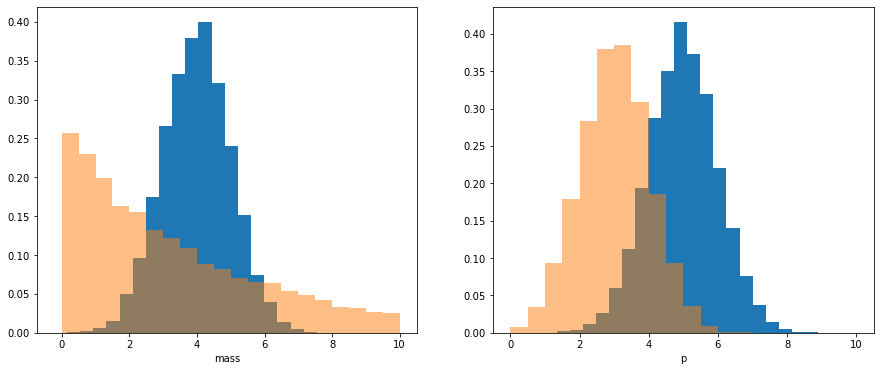

In [9]:
plt.figure(figsize=[15, 6])
plt.subplot(121)

plt.hist(sig_mass, bins=20, density=True)
plt.hist(bck_mass, bins=20, density=True, range=(0, 10), alpha=0.5)
plt.xlabel('mass')

plt.subplot(122)

plt.hist(sig_p, bins=20, density=True)
plt.hist(bck_p, bins=20, density=True, range=(0, 10), alpha=0.5)
plt.xlabel('p');

Text(0.5, 0, 'p')

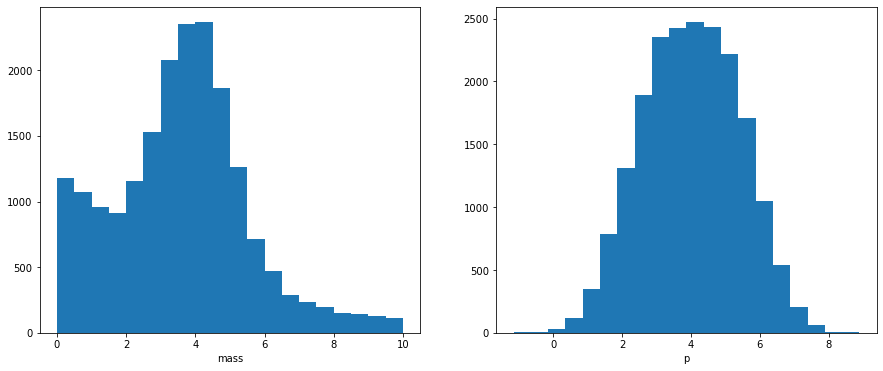

In [15]:
plt.figure(figsize=[15, 6])
plt.subplot(121)
plt.hist(mass, bins=20, range=(0, 10))
plt.xlabel('mass')

plt.subplot(122)
plt.hist(p, bins=20)
plt.xlabel('p')

## sWeights

### Fit
After fitting we would get

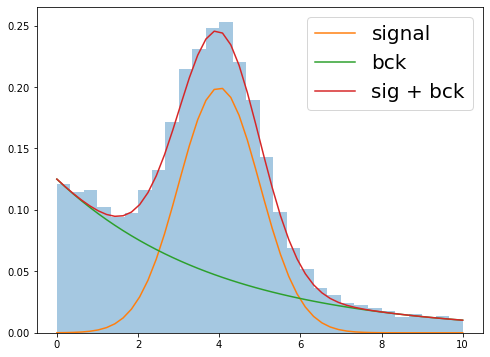

In [16]:
plt.figure(figsize=[8, 6])
x = np.linspace(0, 10)
plt.hist(mass, bins=30, range=[0, 10], density=True, alpha=0.4)
plt.plot(x, norm.pdf(x, loc=4, scale=1) / 2., label='signal')
plt.plot(x, expon.pdf(x, scale=4) / 2., label='bck')
plt.plot(x, 0.5 * (norm.pdf(x, loc=4, scale=1) + expon.pdf(x, scale=4)), label='sig + bck')
plt.legend(fontsize=20)

### Probability of being signal/background
We can estimate the number of signal and background events by getting for each event the probability that is is signal or background

In [22]:
# pandas dictionnary with the probabilities of having a mass
# sig_mass_distr.pdf would be the fitted mass pdf of the signal
# mass is the numpy array of all the masses
probs = pandas.DataFrame(dict(sig=sig_mass_distr.pdf(mass), bck=bck_mass_distr.pdf(mass)))
# probs_sum = probs.sum(axis=1) # sum sig + bck --> pd df with only one column sig + bck
probs = probs.div(probs.sum(axis=1), axis=0) # divide each events by probs.sum(axis=1) for normalisation

# probs['sig'] = probability of being a signal for the given mass 'mass'
# probs['bck'] = probability of being a background for the given mass 'bck'

((0.0, 10.0),
 Text(0.5, 0, 'mass'))

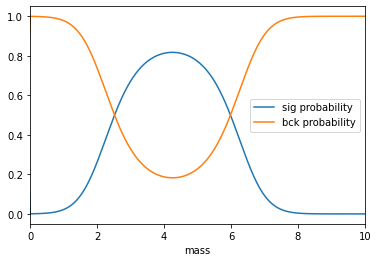

In [23]:
plt.plot(mass, probs.sig, label='sig probability')
plt.plot(mass, probs.bck, label='bck probability')
plt.xlim(, 10)
plt.legend()
plt.xlabel('$m(3\pi)$')

### Apply sPlot

In [25]:
from hep_ml import splot

/afs/cern.ch/work/c/correian/miniconda/envs/bd2dst3pi_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [26]:
# Compute the sWeights from probabilities
sWeights = splot.compute_sweights(probs)

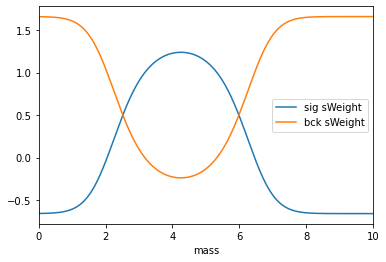

In [27]:
# Plot the sWeights (can be negative to compensate the contributions of other classes)
plt.plot(mass, sWeights.sig, label='sig sWeight')
plt.plot(mass, sWeights.bck, label='bck sWeight')
plt.xlim(0, 10), plt.legend(), plt.xlabel('mass')

### Using sWeights to reconstruct initial distribution

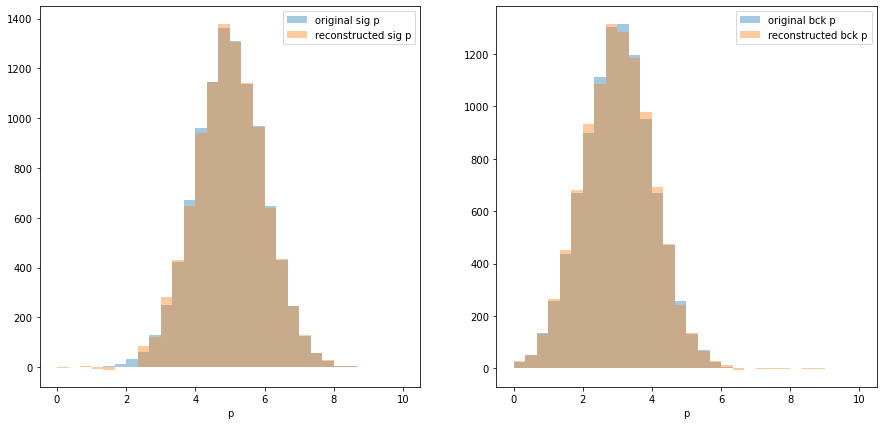

In [29]:
# The weights are given by sWeights.sig and sWeights.bck
plt.figure(figsize=[15, 7])
plt.subplot(121)
hist_conf = dict(bins=30, alpha=0.4, range=[0, 10])
plt.hist(sig_p, label='original sig p', **hist_conf)
plt.hist(p, weights=sWeights.sig, label='reconstructed sig p', **hist_conf)
plt.xlabel('p'), plt.legend()

plt.subplot(122)
plt.hist(bck_p, label='original bck p', **hist_conf)
plt.hist(p, weights=sWeights.bck, label='reconstructed bck p', **hist_conf)
plt.xlabel('p'), plt.legend()
pass

## Requirements
For this sPlots technique to wrok, the reconstructed variable (e.g., p) and splotted variables must be **statistically independent** for each class

In [32]:
## Correlation between both
np.corrcoef(abs(mass-4), p) [0, 1]

-0.012005713738866912

In [33]:
np.corrcoef(abs(mass-4), p)

array([[ 1.        , -0.34644266],
       [-0.34644266,  1.        ]])

In [34]:
print(np.corrcoef(abs(sig_mass - 4), sig_p)[0, 1])
print(np.corrcoef(abs(bck_mass - 4), bck_p)[0, 1])

-0.021529073721474088
-0.012176920093261573


(Text(0.5, 0, 'mass'), <matplotlib.legend.Legend at 0x7fe71df97a10>)

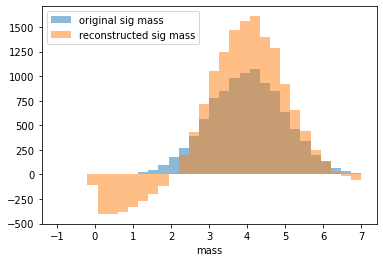

In [36]:
hist_conf = dict(bins=30, alpha=0.5, range=[-1, 7])
plt.hist(sig_mass, label='original sig mass', **hist_conf)
plt.hist(mass, weights=sWeights.sig, label='reconstructed sig mass', **hist_conf)
plt.xlabel('mass'), plt.legend()